#**Descripción del problema:**

Nuestro propósito en este proyecto, es predecir la localización de las Bounding Boxes de distintos objetos, tomando como punto de partida el dataset de Open Images V6 https://storage.googleapis.com/openimages/web/index.html.

Este Dataset está formado por aproximadamente 16 millones de bounding boxes para más de 600 categorías; por tanto, dado que no se poseen los recursos computacionales suficientes para realizar este trabajo completamente, solo se trabajará con una pequeña porción de los datos, aplicando transfer learning a una red neuronal para aprovechar arquitecturas ya entrenadas y muy bien definidas.

#Carga de los datos

In [ ]:
!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.2 MB/s 
     |████████████████████████████████| 135 kB 52.6 MB/s 
     |████████████████████████████████| 29.2 MB 1.3 MB/s 
     |████████████████████████████████| 61 kB 299 kB/s 
     |████████████████████████████████| 508 kB 71.4 MB/s 
     |████████████████████████████████| 563 kB 73.6 MB/s 
     |████████████████████████████████| 106 kB 93.9 MB/s 
     |████████████████████████████████| 132 kB 68.3 MB/s 
     |████████████████████████████████| 133 kB 80.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 79.9 MB 1.1 MB/s 
     |████████████████████████████████| 13.2 MB 59.7 MB/s 
     |████████████████████████████████| 226 kB 97.0 MB/s 
     |████████████████████████████████| 47 kB 3.6 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████|

In [ ]:
!pip install opencv-python-headless==4.5.4.60 fiftyone
import fiftyone as fo
import fiftyone.zoo as foz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47.6 MB 208 kB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Migrating database to v0.16.5


In [ ]:
!apt update
!apt upgrade

In [ ]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf

Ahora vamos a descargar los datos de entrenamiento para hacer el fine-tunnig de la red neuronal.

En la siguiente línea de código podemos ver la clases que contiene este dataset, de las cuales solo utilizaremos algunas de ellas.


In [ ]:
train_dataset=foz.load_zoo_dataset("open-images-v6",  split='train', label_types=['classifications'],
                                   classes=['Ambulance', 'Woman','Traffic light','Traffic sign', 'Truck','Vehicle','Taxi','Tank','Motorcycle',
], max_samples=5000)

 100% |██████|    4.8Gb/4.8Gb [5.0s elapsed, 0s remaining, 1015.7Mb/s]      
 100% |█████████████████| 5000/5000 [10.0m elapsed, 0s remaining, 6.3 files/s]      
Dataset info written to '/root/fiftyone/open-images-v6/info.json'
Loading 'open-images-v6' split 'train'
 100% |███████████████| 5000/5000 [24.4s elapsed, 0s remaining, 293.2 samples/s]      
Dataset 'open-images-v6-train-5000' created


Vamos a visualizar ahora el Dataset que será utilizado durante el entrenamiento

In [ ]:
df=pd.read_csv('/root/fiftyone/open-images-v6/train/labels/classifications.csv')

In [ ]:
df.head(20)

,ImageID,Source,LabelName,Confidence
0,000002b66c9c498e,verification,/m/014j1m,0
1,000002b66c9c498e,verification,/m/014sv8,1
2,000002b66c9c498e,verification,/m/01599,0
3,000002b66c9c498e,verification,/m/015p6,0
4,000002b66c9c498e,verification,/m/015x4r,0
5,000002b66c9c498e,verification,/m/0167gd,0
6,000002b66c9c498e,verification,/m/017ftj,0
7,000002b66c9c498e,verification,/m/01_bhs,0
8,000002b66c9c498e,verification,/m/01bl7v,1
9,000002b66c9c498e,verification,/m/01d40f,1


Primero vamos a entrenar una red neuronal basada en la arquitectura de Darknet 53 con algunas variaciones, dado que no se dispone con el poder computacional suficiente para poder entrenar la red completamente. La arquitectura de Darknet es la sigiente:
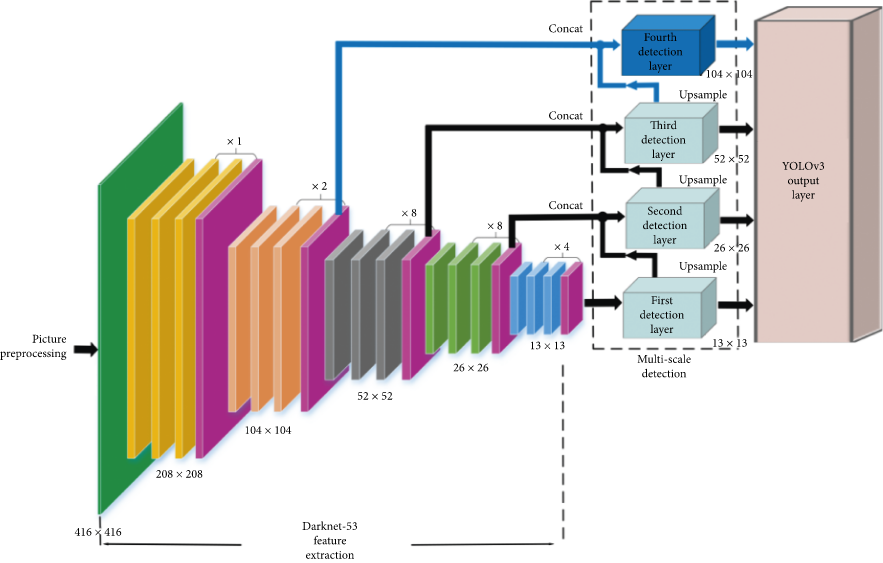

Definimos los bloques convolucionales, ya que vamos a hacer un modelo de entrenamiento por bloques, la mejor manera de hacerlo es ir llamando funciones consecutivamente 

In [ ]:
def conv_block (x, kernel_size, filters=32, padding='same', drop_perc=0.5):

  x=keras.layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dropout(drop_perc)(x)

  x=keras.layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dropout(drop_perc)(x)

  x=keras.layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.Dropout(drop_perc)(x)
  return x

Ya hemos creado los bloques de redes neuronales que van a ser entrenados, ahora debemos crear la arquitectura de la red neuronal

In [ ]:
from tensorflow import keras


In [ ]:
keras.backend.clear_session()
input=keras.layers.Input(shape=[416,416,3])
x=keras.layers.Resizing(height=208, width=208)(input)
x=conv_block(x, kernel_size=203)
#En este momento tenemos la primera etapa de capas convolucionales, ahora vamos a calcular 
#la segunda, para dejarla del tamaño de 104x104 debemos utilizar un kernel de 105
x=conv_block(x, kernel_size=105, filters=64)
x=conv_block(x, kernel_size=105, filters=64)
x=conv_block(x, kernel_size=105, filters=64)

#Las imagenes de la segunda capa tienen un tamaño de 52*52, por tanto el tamaño 
#del kernel debe ser de 53
x=conv_block(x, kernel_size=53, filters=128)
x=conv_block(x, kernel_size=53, filters=128)
x=conv_block(x, kernel_size=53, filters=128)
# Ahora vamos a colocar el cuarto bloque de neuronas convolucionales, las cuales 
# traen una tamaño de imagen de 26*26, port tanto el kernel debe ser de 27*27 
x=conv_block(x, kernel_size=27, filters=256)
x=conv_block(x, kernel_size=27, filters=256)
x=conv_block(x, kernel_size=27, filters=256)
# El utlimo bloque de convolucion es de un tamaño de 13*13, por tanto el kernel es de 14
x=conv_block(x, kernel_size=13, filters=512)
x=conv_block(x, kernel_size=13, filters=512)
x=conv_block(x, kernel_size=13, filters=512)

model=keras.Model(inputs=[input], outputs=[x])
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cb=keras.callbacks.ModelCheckpoint('Model_saved', save_freq='epoch')

In [ ]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['acc'] )

In [ ]:
model.summary()

#Métricas de evaluación

##IoU (Intersection over Union)

#Desempeño deseable en producción